# TP4 : Music Information Retrieval


Nom : Victoria NGUYEN
28604687

Date : 20/12/2023

Le but de ce TP est d'implémenter un réseau de neuronnes permettant la séparation de voix chantees. On implémente ici un réseau U-Net, inspiré de l'article : https://openaccess.city.ac.uk/id/eprint/19289/1/.

Pour le lancer, il faut telecharger la base de données MUSDB version longue. Si vous voulez lancer le code, il faut remplacer la variable ```PATH``` par le chemin de votre dossier MUSDB18.


**Le reseau de neuronnes est entrainé sur les GPU de Google Colab.**

In [ ]:
path ="/home/spi-2019/Téléchargements/musdb18_long"

Les librairies nécéessaires :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import musdb
import librosa
from scipy import signal
import IPython.display as ipd
import librosa
import random
import tensorflow as tf
import matplotlib 
from my_functions import *

## Chargement des données de la base de données MUSDB18

On a deus sous dossiers : un pour les données d'entrainement et un pour les données de test.

In [ ]:
mus_train = musdb.DB(root=path, subsets='train')
mus_test = musdb.DB(root=path, subsets='test')

############################################
print("Nombre de pistes dans la base de données : ", len(mus_train))
print("Nombre de pistes dans la base de données : ", len(mus_test))


#on joue un son de la base de données via librosa
y,sr = librosa.load(mus_train[0].path, sr=None, mono=False)
ipd.Audio(y, rate=sr)

## UNET : creation du modèle

Ci-dessous le schéma du réseau U-Net. Son implémentation est dans le fichier ```my_functions.py```.

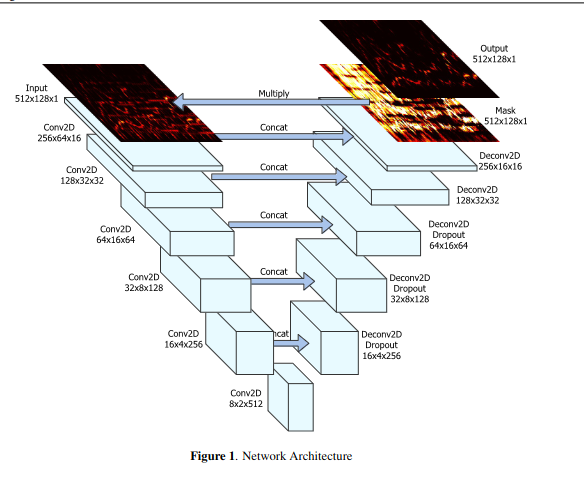

# Creation de la base de train

Pour cela :

1) On choisit aléatoirement n pistes audios.
2) On découpe les données en fenêtres de 128 fenetres

La  fonction ```batchV2```  est implémentée dans le fichier ```my_functions.py```.

In [ ]:
# construction de la base de données X_test X_train

X_train = []
Y_train = []

nb_fenetres_par_piste =  80
nb_appels_a_batch_generation = 50

for i in range(nb_appels_a_batch_generation) :
  #mix sera composé de 4 spectrogrammes de taille 128x512 d'une piste aléatoire
  #donc mix shape = (4,128,512)
  mix, vocals = batchV2(mus_train, nb_fenetres_par_piste)

  
  for j in range(nb_fenetres_par_piste) :
    tmp= mix[j].reshape(512,128,1)
    tmp1 = vocals[j].reshape(512,128,1)
    
    X_train.append(tmp)
    Y_train.append(tmp1)


In [ ]:
print("il y a ",np.array(X_train).shape[0]," spectro dans la base de données d'entrainement")
print(np.array(X_train).shape)
print(np.array(Y_train).shape)


# Creation de la base de test. 


In [ ]:
######################### TEST ##############################
X_test = []
Y_test = []

nb_fenetres_par_piste = 15
nb_appels_a_batch_generation = 15

for i in range(nb_appels_a_batch_generation) :
  #mix sera composé de 4 spectrogrammes de taille 128x512 d'une piste aléatoire
  #donc mix shape = (4,128,512)
  mix, vocals = batchV2(mus_test, nb_fenetres_par_piste)
  
  for j in range(nb_fenetres_par_piste) :
    #on reshape les spectrogrammes pour avoir une taille de 512x128x1
    tmp= mix[j].reshape(512,128,1)
    tmp1 = vocals[j].reshape(512,128,1)

    X_test.append(tmp) #input
    Y_test.append(tmp1) #output

print(np.array(X_test).shape)
print(np.array(Y_test).shape)
print("il y a ",np.array(X_test).shape[0]," spectro dans la base de données de test")

# Creation de la base de validation

In [ ]:
#################### validation

X_val = []
Y_val = []

nb_fenetres_par_piste = 10
nb_appels_a_batch_generation = 10

for i in range(nb_appels_a_batch_generation) :
  #mix sera composé de 4 spectrogrammes de taille 128x512 d'une piste aléatoire
  #donc mix shape = (4,128,512)
  mix, vocals = batchV2(mus_test, nb_fenetres_par_piste)

  for j in range(nb_fenetres_par_piste) :
    #on reshape les spectrogrammes pour avoir une taille de 512x128x1
    tmp= mix[j].reshape(512,128,1)
    tmp1 = vocals[j].reshape(512,128,1)

    X_val.append(tmp)
    Y_val.append(tmp1)

print(np.array(X_val).shape)
print(np.array(Y_val).shape)
print("il y a ",np.array(X_test).shape[0]," spectro dans la base de données de val")

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_val = np.array(X_val)
Y_val = np.array(Y_val)

__On affiche pour voir si les spectogrammes sont bien créés__

In [ ]:
#print
r=198
plot_spectrogramme(X_test[r].reshape(512,128))
plot_spectrogramme(Y_test[r].reshape(512,128))

# on entraine le modèle

Choix des hyperparamètres :

- Optimizer : Adam
- Loss : MSE
- Nombre d'epochs : 35


In [ ]:
lr= 0.01
batch_size= 32
epochs=35

sgd1= tf.keras.optimizers.Adam(learning_rate=lr,ema_momentum=0.9)

model_unet = unet()
model_unet.compile(optimizer=sgd1, loss='mean_squared_error', metrics=['accuracy'])
history = model_unet.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val,Y_val))

# Prediction

In [ ]:
#preodiction
X_test = np.array(X_test)
Y_test = np.array(Y_test)

predictions = model_unet.predict(X_test)


affiche(history)

In [ ]:
#on regarde la sortie pour une donnée de test

k = 11

#ce qu'on veut predire
plot_spectrogramme(Y_test[k].reshape(512,128))
plot_spectrogramme(predictions[k].reshape(512,128))


### Ci dessous une visualisation du résultat 

- En haut : la vérité de terrain
- En bas : la prédiction

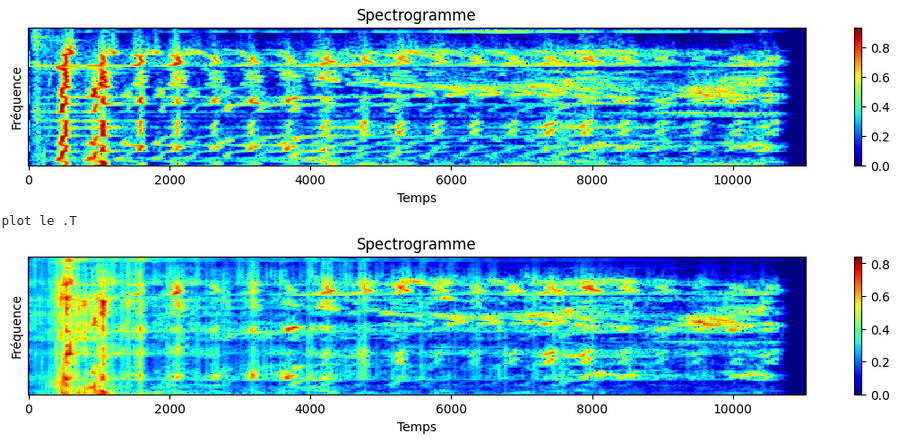





- En haut : la vérité de terrain
- En bas : la prédiction

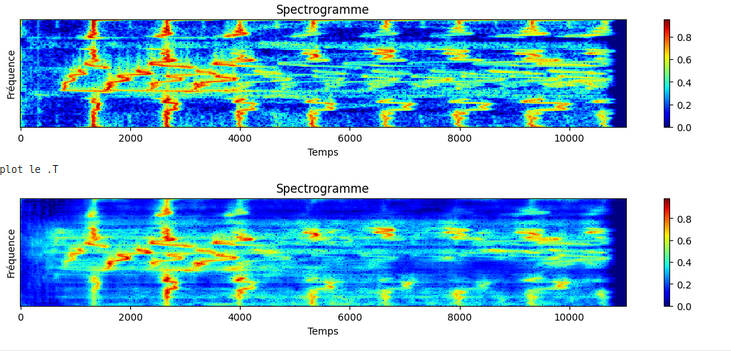

## Exemple de prédiction avec un morceau nouvellement ajouté

In [ ]:
y,sr = librosa.load("/content/musdb18_long/test/Carlos Gonzalez - A Place For Us.stem.mp4", sr=8192, mono=True)
frames = divide_into_frames(y)
predictions = model_unet.predict(np.array(frames))

predictions_reshaped=[]
for elem in predictions:
  tmp = elem.reshape(512,128)
  predictions_reshaped.append(tmp)

res_audio = reconstruct_from_frames(y,predictions_reshaped)

ipd.Audio(res_audio, rate=sr)

# Save 

In [ ]:
import soundfile as sf

sf.write("Carlos Gonzalez - A Place For Us_reconstruit.wav",res_audio,8192)

# Conclusion


L'implémentation du U-NET est relativement facilité grâce a la librairie Keras. 

Le résultat est correct : on reconnait la voix du chanteur. On a cependant un fond sonore qui est présent, similaire au bruit d'un aimant. 

__Quelques remarques :__

- Le temps de calcul environ 30min pour entrainer le modèle.
- La base de train contient un nombre n d'extraits. Ainsi , la fenetre étant aléatoire, il y a des chance que la base soit déséquilibrée. 
